In [1]:
%reload_ext autoreload
%autoreload 2

# Load the data

In [2]:
from result_saver import SaverProvider
provider = SaverProvider()

In [3]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]

# Group job ids by closest calibration date

In [4]:
from datetime import datetime
from Scratch import find_closest_calib_jobs
import pandas as pd

jobs_by_calibration_date = {}
for index, row in md.iterrows():
    if (row['distance'], row['rounds']) not in pairs_to_process:
        continue
    job_id = row['job_id']

    _, _, calib_creation_date = find_closest_calib_jobs(tobecalib_job=job_id, verbose=False)

    if calib_creation_date not in jobs_by_calibration_date.keys():
        jobs_by_calibration_date[calib_creation_date] = [job_id]
    else:
        jobs_by_calibration_date[calib_creation_date].append(job_id)

# Takes 21s

In [5]:
jobs_by_calibration_date

{datetime.datetime(2023, 11, 9, 16, 47, 14, 556645, tzinfo=datetime.timezone.utc): ['cnn25s724wx0008f9kz0',
  'cn6hm589recg008x0jvg',
  'cn6hk3mxhnxg008djq30',
  'cn6h9gpss5h00087k140',
  'cn6h85r62r90008814pg',
  'cn6h75464yf0008g84h0',
  'cn6h5tfss5h00087k0w0',
  'cn6h4f164yf0008g84ag',
  'cn6h3dnxhnxg008djny0',
  'cn6h20ranbvg008dab10',
  'cn6h0mjss5h00087k0a0',
  'cn6gzk664yf0008g83f0',
  'cn6gy68ss5h00087jzsg',
  'cn6gwrkss5h00087jzpg',
  'cn6gvnyxhnxg008djn4g',
  'cn6grptss5h00087jz80',
  'cn6gqa59recg008x0ghg',
  'cn6gnxzss5h00087jyz0',
  'cn6gmvb62r90008812sg',
  'cn6gee1anbvg008da9k0',
  'cn6gczv9recg008x0fng',
  'cn6gbx79recg008x0ff0',
  'cn6gaga62r90008811tg',
  'cn6g93cxhnxg008djkwg',
  'cn6g81rss5h00087jxeg',
  'cn6g6mtxhnxg008djkkg',
  'cn6g57c62r900088110g',
  'cn6g44862r90008810ng',
  'cn6bdpevayrg008ermxg',
  'cn6bca1rmwhg008k4xx0',
  'cn6bb7wrmwhg008k4xa0',
  'cn6b9pprmwhg008k4x60',
  'cn6b89s3r3vg008fcvzg',
  'cn6b76wrmwhg008k4x20',
  'cn6b5v7p1am0008qeza0',
  'cn6b4

# Decode the data and save results

In [7]:
import json

import pymatching
import stim 
from soft_info import get_noise_dict_from_backend, get_avgs_from_dict, find_longest_path_in_hex, get_repcode_IQ_map
import cpp_soft_info
from Scratch import load_calibration_memory, create_or_load_kde_grid

_DETAILED = False

rel_error = 1
_RESETS = False

# KDE BANDWIDTHS
lin = [0.4, 0.7, 20]
num_points = 51

# lin = [0.6, 0.7, 1]
# num_points = 2

bandwidths = np.linspace(lin[0], lin[1], lin[2])




for calib_date in jobs_by_calibration_date.keys():

    # get the noise dict of that date
    noise_dict = get_noise_dict_from_backend(provider, DEVICE, date = calib_date)

    # get the KDE of that date
    all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=calib_date)
    kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=51) # Less num_points bcs just 1 bandwidth

    # get the kde_grid of that date
    grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, tobecalib_backend=DEVICE, other_date=calib_date, num_grid_points=300, num_std_dev=2)

    # get the longest path of that device
    longest_path, _, _ = find_longest_path_in_hex(provider.get_backend(DEVICE))

    # decode each job of that date
    for job_id in tqdm(jobs_by_calibration_date[calib_date], desc=f"Decoding jobs of {calib_date} calibration"):
        distance = md[md["job_id"] == job_id]["distance"].values[0]
        rounds = md[md["job_id"] == job_id]["rounds"].values[0]
        IQ_data = provider.retrieve_job(job_id).result().get_memory()

        # Get the layout for the avgs
        bounded_path = longest_path[:2 * distance - 1]
        layout = bounded_path[1::2] + bounded_path[::2]
        qubit_mapping = get_repcode_IQ_map(layout, rounds)

        # Get the avgs
        avgs = get_avgs_from_dict(noise_dict, layout)

        # Initialize the stim model
        circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=distance,
                                rounds=rounds,
                                after_clifford_depolarization=avgs["two_gate"], #two-qubit-fidelity,
                                after_reset_flip_probability=0 if not _RESETS else avgs["readout"], #reset error
                                before_measure_flip_probability=avgs["readout"], #measurement error,
                                before_round_data_depolarization=avgs["idle"]) #idle error)
        model = circuit.detector_error_model(decompose_errors=False)
        matching = pymatching.Matching.from_detector_error_model(model)

        ############# DECODING ##############

        for nb_intervals in np.logspace(np.log2(2), np.log2(2**10), 75, base=2):
            # nb_intervals = int(nb_intervals)
            result_grid = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                            rounds, int(LOGICAL), _RESETS, qubit_mapping, grid_dict,
                                            processed_scaler_dict, _detailed=_DETAILED, nb_intervals=nb_intervals)

            result_grid_json  = {
                "decoding": "grid",
                "num_errors": result_grid.num_errors,
                "nb_intervals": nb_intervals,
            }

            result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, rounds, int(LOGICAL), _RESETS, 
                                            qubit_mapping, kde_dict, _DETAILED, relError=rel_error, absError=-1,
                                            nb_intervals=nb_intervals, interval_offset=0.5)
            
            result_kde_json = {
                "decoding": "kde_0.5",
                "num_errors": result_kde.num_errors,
                "nb_intervals": round(nb_intervals, 3),
                "additional_info": {            
                    "rel_error": rel_error,
                    "bandwidth_linspace": lin,
                    "num_points_bandwidths": num_points
                },
            }


            ############# SAVING THE RESULT ##############

            with open(f"../results/infoPerfo_v2.json", "r") as f:
                data = json.load(f)
                if job_id not in data.keys():
                    data[job_id] = [result_grid_json, result_kde_json]
                else:
                    data[job_id].append(result_grid_json)
                    data[job_id].append(result_kde_json)
            
            with open(f"../results/infoPerfo_v2.json", "w") as f:
                json.dump(data, f, indent=4)



Found jobs for backend ibm_sherbrooke with closest execution date 2023-11-09 20:02:27+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-11-09 20:02:27+00:00.
Searching for ibm_sherbrooke and 23.11.09_16h47_300pts_2std


Decoding jobs of 2023-11-09 16:47:14.556645+00:00 calibration: 100%|██████████| 46/46 [7:44:24<00:00, 605.75s/it]  


Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


Decoding jobs of 2023-10-27 07:46:44.189709+00:00 calibration: 100%|██████████| 7/7 [1:08:40<00:00, 588.57s/it]


# What number of intervals to use

[   2.            5.65685425   16.           45.254834    128.
  362.03867197 1024.        ]


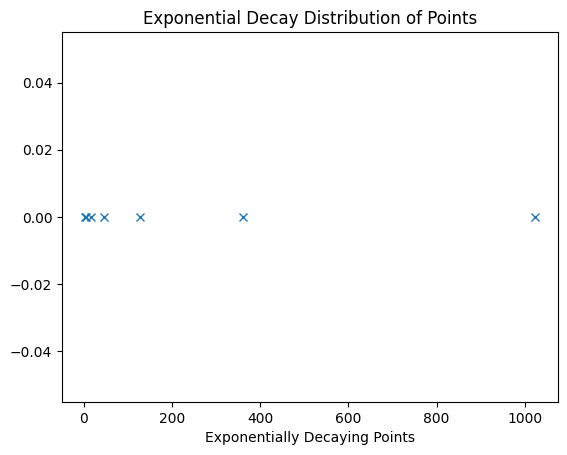

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate exponentially decaying points
# Start from log2(1) to log2(2**10) to get a range from 1 to 1024
# Since we want decay, we invert the start and stop in the logspace function
nb_intervals = np.logspace(np.log2(2), np.log2(2**10), 7, base=2)

print(nb_intervals)

# Plotting the points on a line
plt.plot(nb_intervals, np.zeros_like(nb_intervals), 'x')  # Plot on a line (y=0)
plt.xlabel('Exponentially Decaying Points')
plt.title('Exponential Decay Distribution of Points')
plt.show()


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 25, 27, 30, 32, 35, 38, 42, 45, 49, 54, 58, 63, 69, 75, 82, 89, 97, 105, 114, 124, 135, 147, 160, 174, 190, 206, 225, 244, 266, 289, 315, 342, 372, 405, 441, 480, 522, 568, 617, 672, 731, 795, 865, 941, 1024]
64


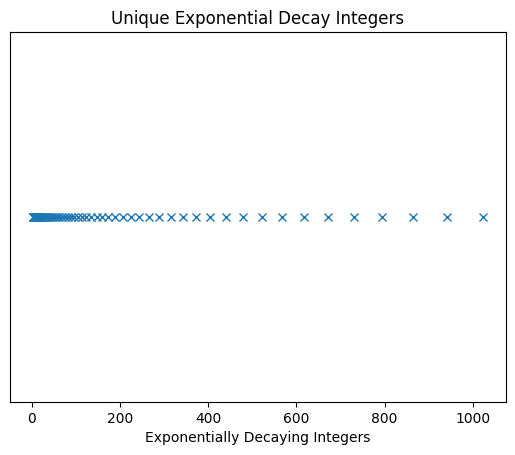

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_exponential_decay_integers(start, end, num_points):
    # Generate points on a log scale
    points = np.logspace(np.log2(start), np.log2(end), num_points, base=2)
    # Round points to nearest integer and ensure uniqueness
    unique_integers = sorted(set([int(round(point)) for point in points]))
    return unique_integers

# Parameters
start = 2
end = 2**10
num_points = 75

# Generate unique, exponentially decaying integers
unique_integers = generate_exponential_decay_integers(start, end, num_points)

print(unique_integers)
print(len(unique_integers))
# Plotting
plt.plot(unique_integers, np.zeros_like(unique_integers), 'x')
plt.xlabel('Exponentially Decaying Integers')
plt.title('Unique Exponential Decay Integers')
plt.yticks([])  # Hide y-axis ticks
plt.show()


In [10]:
import json

import pymatching
import stim 
from soft_info import get_noise_dict_from_backend, get_avgs_from_dict, find_longest_path_in_hex, get_repcode_IQ_map
import cpp_soft_info
from Scratch import load_calibration_memory, create_or_load_kde_grid

_DETAILED = False

rel_error = 1
_RESETS = False

# KDE BANDWIDTHS
lin = [0.4, 0.7, 20]
num_points = 51

# lin = [0.6, 0.7, 1]
# num_points = 2

bandwidths = np.linspace(lin[0], lin[1], lin[2])




for calib_date in jobs_by_calibration_date.keys():

    # get the noise dict of that date
    noise_dict = get_noise_dict_from_backend(provider, DEVICE, date = calib_date)

    # get the KDE of that date
    all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=calib_date)
    kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=51) # Less num_points bcs just 1 bandwidth

    # get the kde_grid of that date
    grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, tobecalib_backend=DEVICE, other_date=calib_date, num_grid_points=300, num_std_dev=2)

    # get the longest path of that device
    longest_path, _, _ = find_longest_path_in_hex(provider.get_backend(DEVICE))

    # decode each job of that date
    for job_id in tqdm(jobs_by_calibration_date[calib_date], desc=f"Decoding jobs of {calib_date} calibration"):
        distance = md[md["job_id"] == job_id]["distance"].values[0]
        rounds = md[md["job_id"] == job_id]["rounds"].values[0]
        IQ_data = provider.retrieve_job(job_id).result().get_memory()

        # Get the layout for the avgs
        bounded_path = longest_path[:2 * distance - 1]
        layout = bounded_path[1::2] + bounded_path[::2]
        qubit_mapping = get_repcode_IQ_map(layout, rounds)

        # Get the avgs
        avgs = get_avgs_from_dict(noise_dict, layout)

        # Initialize the stim model
        circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=distance,
                                rounds=rounds,
                                after_clifford_depolarization=avgs["two_gate"], #two-qubit-fidelity,
                                after_reset_flip_probability=0 if not _RESETS else avgs["readout"], #reset error
                                before_measure_flip_probability=avgs["readout"], #measurement error,
                                before_round_data_depolarization=avgs["idle"]) #idle error)
        model = circuit.detector_error_model(decompose_errors=False)
        matching = pymatching.Matching.from_detector_error_model(model)

        ############# DECODING ##############

        for nb_intervals in generate_exponential_decay_integers(2, 2**10, 60):
            # nb_intervals = int(nb_intervals)
            result_grid = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                            rounds, int(LOGICAL), _RESETS, qubit_mapping, grid_dict,
                                            processed_scaler_dict, _detailed=_DETAILED, nb_intervals=nb_intervals)

            result_grid_json  = {
                "decoding": "grid",
                "num_errors": result_grid.num_errors,
                "nb_intervals": nb_intervals,
            }

            result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, rounds, int(LOGICAL), _RESETS, 
                                            qubit_mapping, kde_dict, _DETAILED, relError=rel_error, absError=-1,
                                            nb_intervals=nb_intervals, interval_offset=0)
            
            result_kde_json = {
                "decoding": "kde_0.5",
                "num_errors": result_kde.num_errors,
                "nb_intervals": round(nb_intervals, 3),
                "additional_info": {            
                    "rel_error": rel_error,
                    "bandwidth_linspace": lin,
                    "num_points_bandwidths": num_points
                },
            }


            ############# SAVING THE RESULT ##############

            with open(f"../results/infoPerfo_v3.json", "r") as f:
                data = json.load(f)
                if job_id not in data.keys():
                    data[job_id] = [result_grid_json, result_kde_json]
                else:
                    data[job_id].append(result_grid_json)
                    data[job_id].append(result_kde_json)
            
            with open(f"../results/infoPerfo_v3.json", "w") as f:
                json.dump(data, f, indent=4)



Found jobs for backend ibm_sherbrooke with closest execution date 2023-11-09 20:02:27+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-11-09 20:02:27+00:00.
Searching for ibm_sherbrooke and 23.11.09_16h47_300pts_2std


Decoding jobs of 2023-11-09 16:47:14.556645+00:00 calibration: 100%|██████████| 46/46 [6:31:02<00:00, 510.06s/it]   


Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


Decoding jobs of 2023-10-27 07:46:44.189709+00:00 calibration: 100%|██████████| 7/7 [1:05:06<00:00, 558.06s/it] 
